# Sushi Restaurant in Toronto

-------------------------------------------------------------------------------------------------

## 0 Contents

  **1. [Introduction/Business Problem](#introduction)** <br/>
  > **1.1 [Define the Constraints](#constraints)** <br/> 
  
  **2. [Data](#data)** <br/>
  > **2.1 [Data Requirements](#data_requirements)** <br/>
       >> **2.1.1 [A List of Neigborhoods in Toronto Along with Their Latitude and Longitude Values](#part211)** <br/>
       >> **2.1.2 [Foursquare Data Containing Venue Information in Toronto Neighborhoods](#part212)** <br/> 
       
  > **2.2 [Data Preparation](#data_prep)** <br/> 
  
  **3. [Methodology](#methodology)** <br/>
  > **3.1 [Data Exploration, Analysis and Insights](#exploration)** <br>
  > **3.2 [Clustering](#clustering)** <br>
  
  **4. [Results and Discussion](#results)** <br/>
  **5. [Conclusion](#conclusion)** <br/>

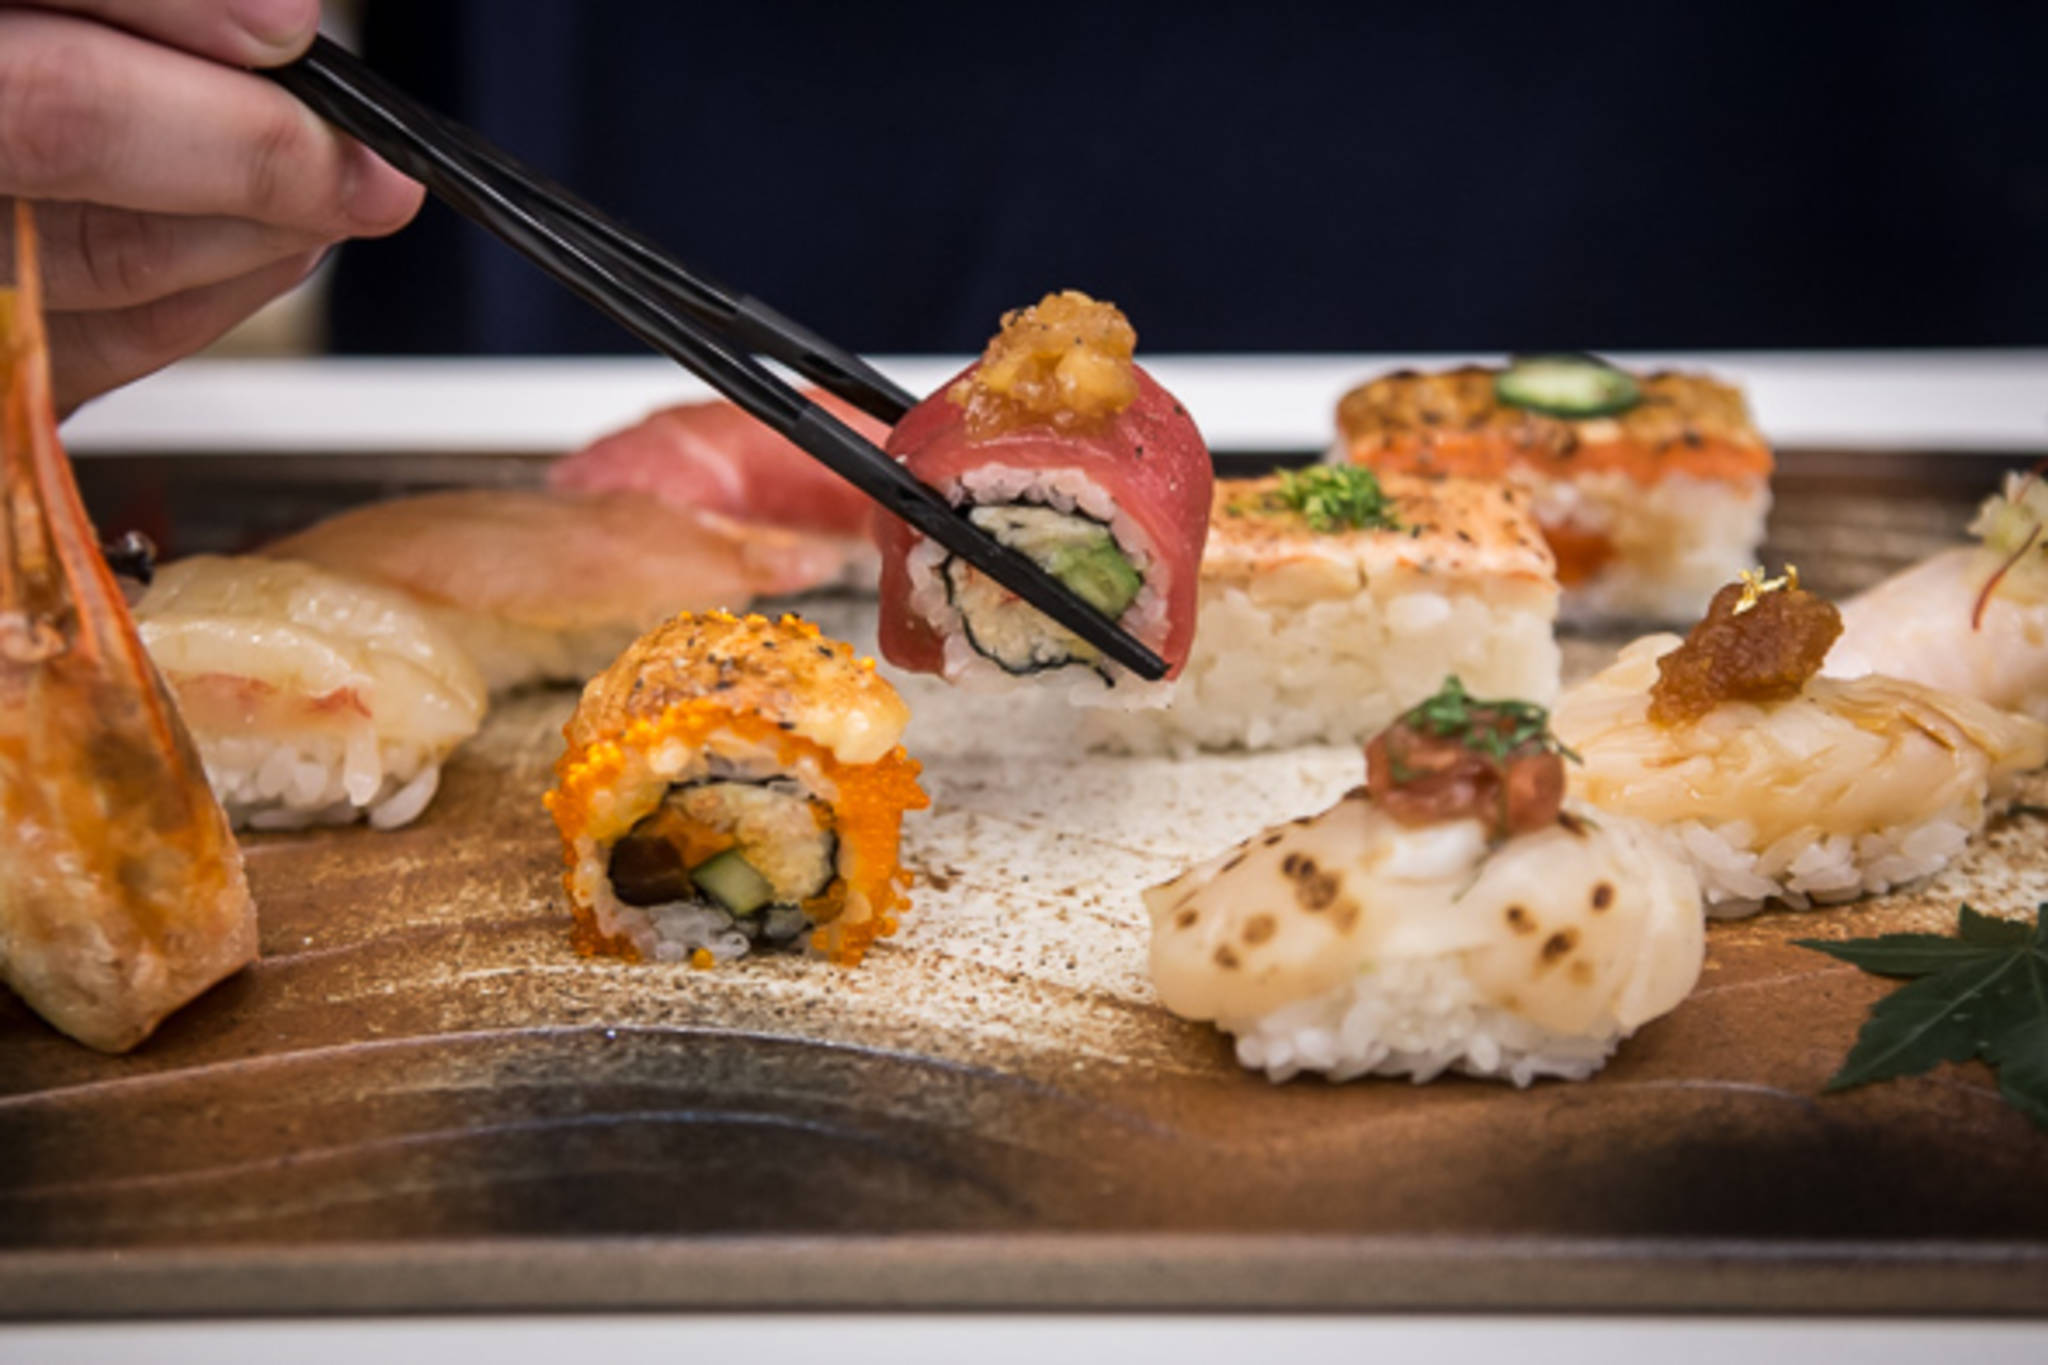

In [1]:
from IPython.display import Image
Image(filename='sushi.jpg')

-------------------------------------------------------------------------------------------------

## 1 Introduction/Business Problem <a name="introduction"></a>
> <div style="text-align: justify"> A friend of mine recently quit her job in order to make her dreams come true. Her plan is to move to Toronto to become close to her Japanese boyfriend she met last year. He is a Phd student in Food Sciences, and their plan is to open a Sushi restaurant there, after her boyfriend's graduation. Last week, my friend asked me for my help to choose the best neighborhood to open it. Later on I decided to make some analysis using my data science skills in order to help her. I hope the my recomendations would help them in their future life.</div>

> ### 1.1 Define the Constraints <a name="constraints"></a>
>> <div style="text-align: justify"> Before starting the analysis, I tried to get some insights from her and asked her if she had any preferences in mind. She told me that it would be nice to open it at somewhere lively, and they did not have any cost constraints since she has plenty of money at hand after saving up so many years in her latest job. In addition, she told me that it would be wise to choose a neighborhood famous for its restaurants but lack of any Sushi place.</div>

-------------------------------------------------------------------------------------------------

## 2 Data <a name="data"></a>

> ### 2.1 Data Requirements   <a name="data_requirements"></a>
>> ### 2.1.1  A List of Neigborhoods in Toronto Along with Their Latitude and Longitude Values <a name="part211"></a>
>>> <div style="text-align: justify"> Toronto neighborhood data containing postal codes, borough names and neighborhood names can be found in following wikipedia page 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'. Since mentioned url does not contain latitude and longitude values for each neighborhood, we also need this url: http://cocl.us/Geospatial_data. The second url contains postal codes as well as latitude and longitude values. Therefore, it would be easy to merge the two datasets to obtain Toronto information. Latitude and longitude values in this merged dataset will later be necessary to get foursquare data described in 2.1.2. <br>
>> ### 2.1.2 Foursquare Data Containing Venue Information in Toronto Neighborhoods <a name="part212"></a>
>>> <div style="text-align: justify"> Since the most important constraint I have at hand is about finding a lively neighborhood occupied by restaurants, a quick entrance to the problem would be finding 100 nearby venues in 1km radius of each Toronto neighborhood, get their categories and decide which ones satisfy this condition. Demographic and population data are ignored in this analysis, since once I get those categories I would infer about the popularity and density of the neighborhoods by analyzing frequencies of venue categories. This leads me to use the foursquare api to get this information. Once I get the venue data of Toronto from Foursqure api, merged data would contain ( last 4 comes from foursquare api ):<br>
- Name of the neighborhood, <br>
- Latitude of the neighborhood,<br>
- Longitute of neighborhood, <br>
- Name of the venue,<br>
- Latitude of the venue,<br>
- Longitute of the venue,<br> 
- Category of the venue.</div>

> ### 2.2 Data Preparation <a name="data_prep"></a>
>> After defining the data requirements and the sources to obtain the data in section 2.1 , now I am ready to explore, clean and make data ready for the analysis.

-------------------------------------------------------------------------------------------------

## 2.2 Data Preparation

**Import necessary libraries**

In [2]:
#!pip install beautifulsoup4
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
from matplotlib import pyplot as plt

**Read neighborhood table from wikipedia page**

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response=requests.get(url)
html = response.text
page = BeautifulSoup(html,'html.parser')
table = page.find_all('table')[0]
df = pd.read_html(str(table))
neighbourhood=pd.DataFrame(df[0])
neighbourhood = neighbourhood.rename(columns={0:'Postal Code',1:'Borough',2:'Neighborhood'})
neighbourhood.drop(index=0,inplace=True)

print(neighbourhood.shape)
neighbourhood.head()

(179, 3)


,Postal Code,Borough,Neighborhood
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"


**Remove rows where borough equals "Not assigned"**

In [4]:
neighbourhood=neighbourhood[~(neighbourhood.Borough=="Not assigned")]
neighbourhood.shape

(103, 3)

**Get boroughs that contain the word Toronto**

In [5]:
neighbourhood["to_filter"]=neighbourhood["Borough"].apply(lambda x: "Toronto" in x)
neighbourhood=neighbourhood[neighbourhood.to_filter==1]
neighbourhood.drop(columns=["to_filter"],inplace=True)
print(neighbourhood.shape)
neighbourhood.head()

(39, 3)


,Postal Code,Borough,Neighborhood
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
13,M5B,Downtown Toronto,"Garden District, Ryerson"
22,M5C,Downtown Toronto,St. James Town
30,M4E,East Toronto,The Beaches


**Get coordinates for Toronto**

In [6]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Ontario are 43.6534817, -79.3839347.


**Read downloaded csv from (http://cocl.us/Geospatial_data) for getting geographical coordinates of each postal code**

In [7]:
coords=pd.read_csv("Geospatial_Coordinates.csv")
coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Map coordinates to postal codes in toronto data**

In [8]:
map_latitude = dict(coords[['Postal Code', 'Latitude']].values)
neighbourhood["Latitude"]= neighbourhood['Postal Code'].map(map_latitude)

map_longitude = dict(coords[['Postal Code', 'Longitude']].values)
neighbourhood["Longitude"]= neighbourhood['Postal Code'].map(map_longitude)

neighbourhood.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
13,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
22,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
30,M4E,East Toronto,The Beaches,43.676357,-79.293031


List of neigborhoods in Toronto along with their latitude and longitude values described in section 2.1.1 is ready. Let's visualize those neighborhoods

In [9]:
# create map
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon in zip(neighbourhood['Latitude'], neighbourhood['Longitude']):
    folium.CircleMarker([lat, lon], radius=2, color='blue', 
    fill=True, fill_color='blue', fill_opacity=1).add_to(map_toronto) 

map_toronto

**Creditentials for foursquare api**

In [10]:
import getpass
CLIENT_ID = getpass.getpass('Enter CLIENT_ID : ')
CLIENT_SECRET=getpass.getpass('Enter CLIENT_SECRET : ')

Enter CLIENT_ID : ········
Enter CLIENT_SECRET : ········


**Function for getting 100 venues near 1 km radius of Toronto neighbourhoods**

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
VERSION=20180605
toronto_venues = getNearbyVenues(names=neighbourhood['Neighborhood'],
                                   latitudes=neighbourhood['Latitude'],
                                   longitudes=neighbourhood['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

(3190, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
3,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
4,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


In [13]:
print('There are {} venues'.format(len(toronto_venues['Venue Category'])),'and {} uniques categories'
      .format(len(toronto_venues['Venue Category'].unique())),'for {} unique neighborhoods.'.format(len(toronto_venues['Neighborhood'].unique())))

There are 3190 venues and 275 uniques categories for 39 unique neighborhoods.


## 3 Methodology <a name="methodology"></a>

### 3.1 Data Exploration, Analysis and Insights <a name="exploration"></a>

One approach for solving the problem would be understanding Toronto neighborhood data by exploring top venue categories. Such analysis would lead us to some important insights such as finding popular, and lively neighborhoods. After finding those neighborhoods, another task is to find restaurant-dense neighborhoods. We need those areas because people already have habits of eating there. However it is obvious that those neighborhoods should be lack of any sushi related restaurants, in order not to face any competitiors.

**Create one hot venue category dataframe**

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
cols=list(toronto_onehot.columns)
cols.remove("Neighborhood")
# move neighborhood column to the first column
fixed_columns = ["Neighborhood"] +cols
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

**Observe most frequent categories in total of all neighborhoods**

Cofee shop appears to be top frequent category and tells a lot about liveliness of a neighborhood. It could be a nice indicator for getting close to where to open my friend's Sushi restarurant.

In [15]:
toronto_onehot_sum=toronto_onehot.sum().reset_index()
toronto_onehot_sum.columns=["category","count"]
toronto_onehot_sum=toronto_onehot_sum.iloc[1:,:]
toronto_onehot_sum.sort_values(by=["count"],ascending=False,inplace=True)
toronto_onehot_sum.head(30)

,category,count
60,Coffee Shop,258
43,Café,185
211,Restaurant,93
190,Park,88
145,Italian Restaurant,83
17,Bakery,74
146,Japanese Restaurant,70
199,Pizza Place,65
244,Sushi Restaurant,58
19,Bar,56


**Get frequency of coffee shops in each neighborhood**

In [16]:
coffee=pd.DataFrame(toronto_onehot[toronto_onehot["Coffee Shop"]==1].groupby(["Neighborhood"]).size()).reset_index()
coffee.columns=["Neighborhood","number of coffee shops"]
coffee.sort_values(by=["number of coffee shops"],ascending=False,inplace=True)

**Get all types of restaurant categories which are not related with sushi**

In [17]:
venue_categories=list(toronto_onehot.columns)
venue_category_selected_restaurant=list(filter(lambda x:("Restaurant" in x) &
                             ("Sushi" not in x) & 
                             ("Japanese" not in x) &
                             ("Chinese" not in x) &
                             ("Korean" not in x) &
                             ("Asian" not in x), 
                             venue_categories))
for rest in venue_category_selected_restaurant:
    print(rest) 

American Restaurant
Belgian Restaurant
Brazilian Restaurant
Cajun / Creole Restaurant
Cantonese Restaurant
Caribbean Restaurant
Comfort Food Restaurant
Cuban Restaurant
Doner Restaurant
Dumpling Restaurant
Eastern European Restaurant
Ethiopian Restaurant
Falafel Restaurant
Fast Food Restaurant
Filipino Restaurant
French Restaurant
German Restaurant
Greek Restaurant
Hawaiian Restaurant
Indian Restaurant
Indonesian Restaurant
Italian Restaurant
Jewish Restaurant
Latin American Restaurant
Mediterranean Restaurant
Mexican Restaurant
Middle Eastern Restaurant
Modern European Restaurant
New American Restaurant
North Indian Restaurant
Pakistani Restaurant
Persian Restaurant
Portuguese Restaurant
Ramen Restaurant
Restaurant
Seafood Restaurant
South American Restaurant
Syrian Restaurant
Taiwanese Restaurant
Tapas Restaurant
Thai Restaurant
Theme Restaurant
Tibetan Restaurant
Turkish Restaurant
Vegetarian / Vegan Restaurant
Vietnamese Restaurant


**Get all sushi related restauran categories**

In [18]:
restaurants_to_exclude=list(set(list(filter(lambda x:("Restaurant" in x),venue_categories)))
                            -set(venue_category_selected_restaurant))

restaurants_to_exclude

['Chinese Restaurant',
 'Asian Restaurant',
 'Korean Restaurant',
 'Sushi Restaurant',
 'Japanese Restaurant',
 'Indian Chinese Restaurant']

**Get non-sushi related restaurant densities of neighborhoods where there is at most one sushi related restaurant**

In [19]:
# Neighborhoods which have at most one sushi related restaurant 

to_exclude=pd.DataFrame(toronto_onehot[["Neighborhood"]+list(restaurants_to_exclude)].groupby(["Neighborhood"]).sum().sum(axis=1)).reset_index()
to_exclude.columns=["neighborhood","count_to_exclude"]
to_exclude=to_exclude[to_exclude["count_to_exclude"]<=1]

selected_restaurants=pd.DataFrame(toronto_onehot.loc[toronto_onehot["Neighborhood"].isin(list(to_exclude.neighborhood)),
                                ["Neighborhood"]+ 
                            venue_category_selected_restaurant].groupby(["Neighborhood"]).sum().sum(axis=1)).reset_index()
selected_restaurants.columns=["Neighborhood","number of selected restaurants"]
selected_restaurants.sort_values(by=["number of selected restaurants"],ascending=False,inplace=True)

**Plot top frequencies for coffee shops and non-sushi related restaurants**

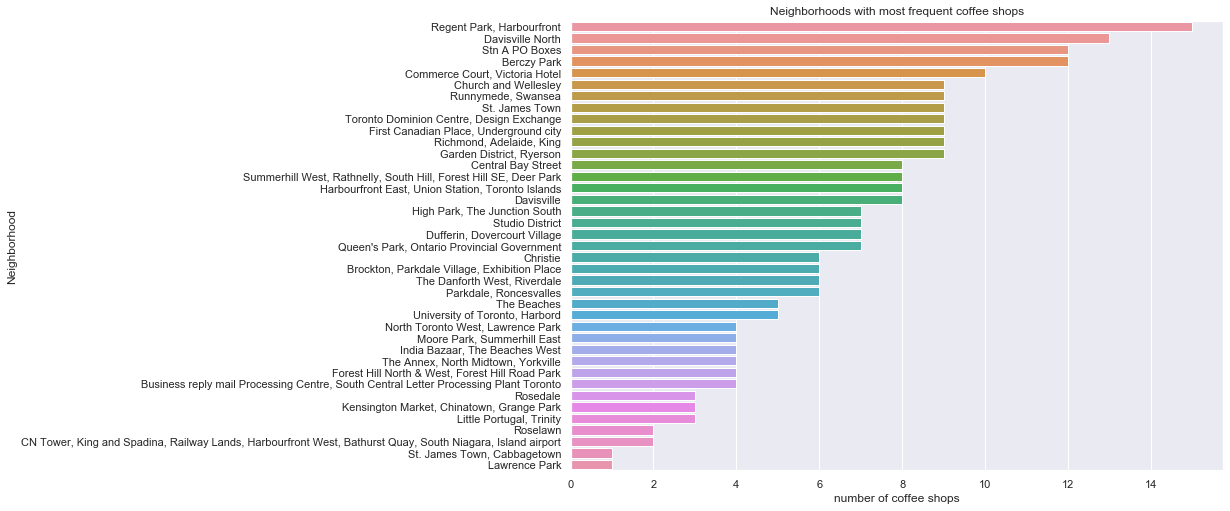

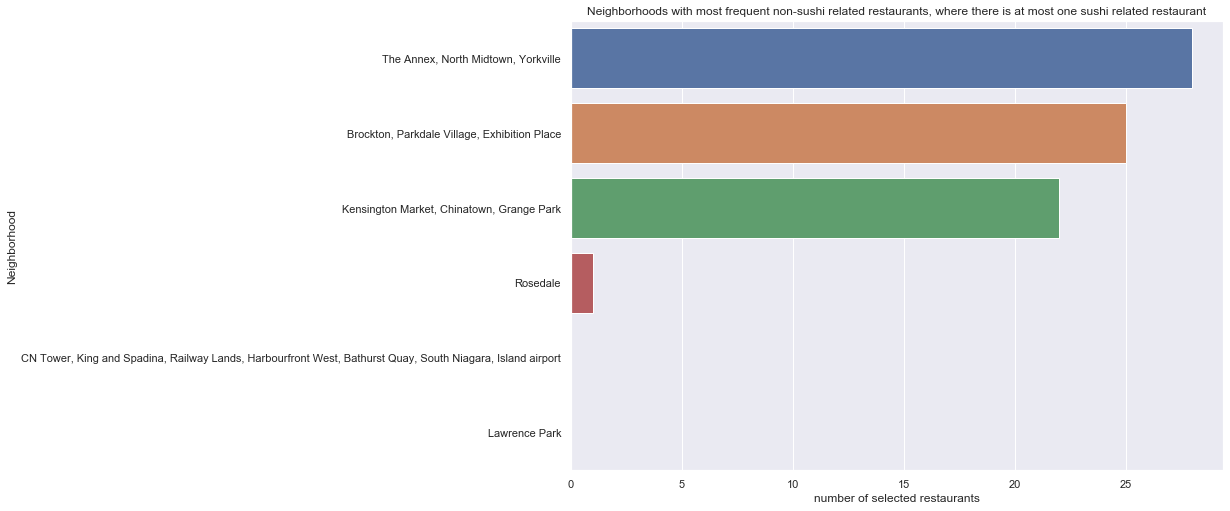

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.barplot(y="Neighborhood", x="number of coffee shops",data=coffee).set_title('Neighborhoods with most frequent coffee shops')
plt.show()
ax = sns.barplot(y="Neighborhood", x="number of selected restaurants",data=selected_restaurants).set_title('Neighborhoods with most frequent non-sushi related restaurants, where there is at most one sushi related restaurant')
plt.show()

**Get coffe shop frequencies for neighborhoods with most frequent non-sushi related restaurants and where there is at most one sushi related restaurant**

In [21]:
coffee[coffee["Neighborhood"].isin(list(selected_restaurants["Neighborhood"]))].head()

,Neighborhood,number of coffee shops
1,"Brockton, Parkdale Village, Exhibition Place",6
34,"The Annex, North Midtown, Yorkville",4
26,Rosedale,3
17,"Kensington Market, Chinatown, Grange Park",3
3,"CN Tower, King and Spadina, Railway Lands, Har...",2


**Brockton, Parkdale Village, Exhibition Place seems a good candidate. Let's show its venue categories**

In [22]:
st=toronto_onehot[toronto_onehot["Neighborhood"]=="Brockton, Parkdale Village, Exhibition Place"]
st_sum=st.sum().reset_index()
st_sum.columns=["category","count"]
st_sum=st_sum.iloc[1:,:]
st_sum.sort_values(by=["count"],ascending=False,inplace=True)
st_sum.head(30)

,category,count
43,Café,8
60,Coffee Shop,6
19,Bar,5
211,Restaurant,5
17,Bakery,4
110,Furniture / Home Store,4
258,Tibetan Restaurant,3
119,Gift Shop,3
266,Vegetarian / Vegan Restaurant,2
257,Thrift / Vintage Store,2


**Let's see other restaurants in this neighborhood**

In [23]:
toronto_venues[(toronto_venues["Neighborhood"]=="Brockton, Parkdale Village, Exhibition Place") & 
               (toronto_venues["Venue Category"]=="Restaurant")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1371,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,Nuit Social,43.642857,-79.425388,Restaurant
1376,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,The Drake Hotel,43.643147,-79.424597,Restaurant
1389,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,Medieval Times,43.632674,-79.425705,Restaurant
1396,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,Vogue Supper Club,43.636951,-79.425446,Restaurant
1444,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,Tibet Kitchen,43.640037,-79.439557,Restaurant


**The Annex, North Midtown, Yorkville is the second good candidate. Let's show its venue categories**

Observing below table, this neigboorhood seems like a more suitable one. There are gyms, museums, bookstores etc. at this part of the city. It looks like a good place where a sushi-lover would visit or live.

In [24]:
com=toronto_onehot[toronto_onehot["Neighborhood"]=="The Annex, North Midtown, Yorkville"]
com_sum=com.sum().reset_index()
com_sum.columns=["category","count"]
com_sum=com_sum.iloc[1:,:]
com_sum.sort_values(by=["count"],ascending=False,inplace=True)
com_sum.head(30)

,category,count
43,Café,6
266,Vegetarian / Vegan Restaurant,5
60,Coffee Shop,4
145,Italian Restaurant,4
17,Bakery,3
211,Restaurant,3
199,Pizza Place,3
122,Grocery Store,3
123,Gym,3
173,Museum,3


### 3.2 Clustering <a name="clustering"></a>

Given my friend's constraints for finding the best neighborhood to open a sushi place, classical data analysis methods applied in section 3.1 were helpful enough for selecting a good candidate. However, another approach could be solving the problem - by a similar approach after getting insights from data - with a machine learning model. 

To do that, I created a model data grouped by all neighboorhoods in Toronto, with 4 features. Those features are,<br>
- number of coffee shops in the neighborhood<br>
- number of sushi related restaurants in the neighborhood<br>
- number of total restaurants in the neighborhood<br>
- number of total venues in the neighborhood<br>

Then I applied a machine learning model with 6 clusters.

**Get number of coffee shops feature** <br>
It was already calculated in section 3.1

In [25]:
coffee.rename(columns={'Neighborhood':'neighborhood'}, inplace=True)
coffee

,neighborhood,number of coffee shops
24,"Regent Park, Harbourfront",15
9,Davisville North,13
31,Stn A PO Boxes,12
0,Berczy Park,12
7,"Commerce Court, Victoria Hotel",10
6,Church and Wellesley,9
28,"Runnymede, Swansea",9
29,St. James Town,9
37,"Toronto Dominion Centre, Design Exchange",9
11,"First Canadian Place, Underground city",9


**Create number of sushi related restaurants feature** 

In [26]:
sushi_related_restaurants=pd.DataFrame(toronto_onehot[["Neighborhood"]+list(restaurants_to_exclude)]
                        .groupby(["Neighborhood"]).sum().sum(axis=1)).reset_index()

sushi_related_restaurants.columns=["neighborhood","number_of_sushi_related_restaurants"]
sushi_related_restaurants

,neighborhood,number_of_sushi_related_restaurants
0,Berczy Park,4
1,"Brockton, Parkdale Village, Exhibition Place",1
2,"Business reply mail Processing Centre, South C...",2
3,"CN Tower, King and Spadina, Railway Lands, Har...",1
4,Central Bay Street,6
5,Christie,15
6,Church and Wellesley,6
7,"Commerce Court, Victoria Hotel",5
8,Davisville,7
9,Davisville North,5


**Create number of all restaurants feature** 

In [28]:
all_restaurants=list(filter(lambda x:("Restaurant" in x),venue_categories))

all_restaurants=pd.DataFrame(toronto_onehot[["Neighborhood"]+list(all_restaurants)]
                        .groupby(["Neighborhood"]).sum().sum(axis=1)).reset_index()

all_restaurants.columns=["neighborhood","number_of_all_restaurants"]
all_restaurants

,neighborhood,number_of_all_restaurants
0,Berczy Park,19
1,"Brockton, Parkdale Village, Exhibition Place",26
2,"Business reply mail Processing Centre, South C...",9
3,"CN Tower, King and Spadina, Railway Lands, Har...",1
4,Central Bay Street,25
5,Christie,34
6,Church and Wellesley,22
7,"Commerce Court, Victoria Hotel",25
8,Davisville,37
9,Davisville North,24


**Create number all venues feature** <br>
This feature would indicate overall liveliness of the neighborhood together with number of coffee shops feature

In [29]:
all_venues=pd.DataFrame(toronto_onehot.groupby(["Neighborhood"]).sum().sum(axis=1)).reset_index()
all_venues.columns=["neighborhood","number_of_all_venues"]
all_venues.sort_values(by=["number_of_all_venues"],ascending=False)

,neighborhood,number_of_all_venues
19,"Little Portugal, Trinity",100
15,"High Park, The Junction South",100
36,"The Danforth West, Riverdale",100
34,"The Annex, North Midtown, Yorkville",100
31,Stn A PO Boxes,100
24,"Regent Park, Harbourfront",100
23,"Queen's Park, Ontario Provincial Government",100
22,"Parkdale, Roncesvalles",100
17,"Kensington Market, Chinatown, Grange Park",100
38,"University of Toronto, Harbord",100


**Merge all features**

In [37]:

toronto_model_data=all_venues.merge(all_restaurants,on="neighborhood",how="left").merge(sushi_related_restaurants,on="neighborhood",how="left").merge(coffee,on="neighborhood",how="left")


In [38]:
toronto_model_data.head()

,neighborhood,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops
0,Berczy Park,99,19,4,12
1,"Brockton, Parkdale Village, Exhibition Place",99,26,1,6
2,"Business reply mail Processing Centre, South C...",50,9,2,4
3,"CN Tower, King and Spadina, Railway Lands, Har...",15,1,1,2
4,Central Bay Street,99,25,6,8


**Fill na values with 0 (i.e for a neighbood with no coffee shops ), and scale frequencies by dividing them to max number of venues for a neighborhood** 



In [39]:
toronto_model_data=toronto_model_data.fillna(0)
neighbours=toronto_model_data.neighborhood
toronto_model_data=toronto_model_data.iloc[:,1:].apply(lambda x: x/100) #neighborhood column omitted

In [40]:
toronto_model_data.head()

,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops
0,0.99,0.19,0.04,0.12
1,0.99,0.26,0.01,0.06
2,0.50,0.09,0.02,0.04
3,0.15,0.01,0.01,0.02
4,0.99,0.25,0.06,0.08


**K-means algorithm with 6 clusters**

In [41]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_model_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 0, 4, 0, 0, 4, 0], dtype=int32)

**Add neighborhood name back, add cluster labels and coordinates to data**

In [42]:
toronto_model_data.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_model_data.insert(0, 'neighborhood', neighbours)

map_latitude = dict(neighbourhood[['Neighborhood', 'Latitude']].values)
toronto_model_data["latitude"]= toronto_model_data['neighborhood'].map(map_latitude)

map_longitude = dict(neighbourhood[['Neighborhood', 'Longitude']].values)
toronto_model_data["longitude"]= toronto_model_data['neighborhood'].map(map_longitude)

In [44]:
toronto_model_data.head()

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
0,Berczy Park,0,0.99,0.19,0.04,0.12,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",0,0.99,0.26,0.01,0.06,43.636847,-79.428191
2,"Business reply mail Processing Centre, South C...",2,0.50,0.09,0.02,0.04,43.662744,-79.321558
3,"CN Tower, King and Spadina, Railway Lands, Har...",1,0.15,0.01,0.01,0.02,43.628947,-79.394420
4,Central Bay Street,0,0.99,0.25,0.06,0.08,43.657952,-79.387383


**Number of neighborhoods assigned to each label**

In [45]:
toronto_model_data.groupby(["Cluster Labels"]).size()

Cluster Labels
0    18
1     4
2     4
3     2
4     7
5     4
dtype: int64

**Averages for each feature by cluster lables**

In [46]:
toronto_model_data.groupby(["Cluster Labels"])["number_of_sushi_related_restaurants"].mean()

Cluster Labels
0    0.041111
1    0.015000
2    0.025000
3    0.030000
4    0.067143
5    0.042500
Name: number_of_sushi_related_restaurants, dtype: float64

In [47]:
toronto_model_data.groupby(["Cluster Labels"])["number_of_all_venues"].mean()

Cluster Labels
0    0.994444
1    0.165000
2    0.447500
3    0.615000
4    0.998571
5    0.800000
Name: number_of_all_venues, dtype: float64

In [48]:
toronto_model_data.groupby(["Cluster Labels"])["number_of_all_restaurants"].mean()

Cluster Labels
0    0.225000
1    0.022500
2    0.102500
3    0.155000
4    0.314286
5    0.197500
Name: number_of_all_restaurants, dtype: float64

In [49]:
toronto_model_data.groupby(["Cluster Labels"])["number of coffee shops"].mean()

Cluster Labels
0    0.087222
1    0.020000
2    0.032500
3    0.055000
4    0.061429
5    0.065000
Name: number of coffee shops, dtype: float64

**Map clusters**

In [66]:

map_toronto= folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for lat,lon,cluster in zip(toronto_model_data['latitude'], toronto_model_data['longitude'],
                   toronto_model_data['Cluster Labels']):
    folium.CircleMarker([lat, lon], radius=2, color=rainbow[cluster-1], fill=True, 
                        fill_color=rainbow[cluster-1], fill_opacity=1).add_to(map_toronto) 

map_toronto

**Analyze each cluster**<br>
Looks like cluster 4 gives high level of total number of venues, medium level for total number of restaurants, low level of total sushi related restaurants and medium level of total coffee shops. Therefore cluster with label 4 fits our criteria. Neighborhood in this cluster which has at most one sushi related restaurant (The Annex, North Midtown, Yorkville) is the same one we obtained at the end of section 3.1.

In [51]:
toronto_model_data[toronto_model_data["Cluster Labels"]==0]

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
0,Berczy Park,0,0.99,0.19,0.04,0.12,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",0,0.99,0.26,0.01,0.06,43.636847,-79.428191
4,Central Bay Street,0,0.99,0.25,0.06,0.08,43.657952,-79.387383
6,Church and Wellesley,0,1.00,0.22,0.06,0.09,43.665860,-79.383160
7,"Commerce Court, Victoria Hotel",0,0.99,0.25,0.05,0.10,43.648198,-79.379817
9,Davisville North,0,1.00,0.24,0.05,0.13,43.712751,-79.390197
11,"First Canadian Place, Underground city",0,0.99,0.22,0.05,0.09,43.648429,-79.382280
14,"Harbourfront East, Union Station, Toronto Islands",0,0.99,0.16,0.06,0.08,43.640816,-79.381752
15,"High Park, The Junction South",0,1.00,0.22,0.03,0.07,43.661608,-79.464763
17,"Kensington Market, Chinatown, Grange Park",0,1.00,0.23,0.01,0.03,43.653206,-79.400049


In [52]:
toronto_model_data[toronto_model_data["Cluster Labels"]==1]

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
3,"CN Tower, King and Spadina, Railway Lands, Har...",1,0.15,0.01,0.01,0.02,43.628947,-79.394420
18,Lawrence Park,1,0.08,0.00,0.00,0.01,43.728020,-79.388790
26,Rosedale,1,0.22,0.02,0.01,0.03,43.679563,-79.377529
27,Roselawn,1,0.21,0.06,0.04,0.02,43.711695,-79.416936


In [53]:
toronto_model_data[toronto_model_data["Cluster Labels"]==2]

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
2,"Business reply mail Processing Centre, South C...",2,0.50,0.09,0.02,0.04,43.662744,-79.321558
12,"Forest Hill North & West, Forest Hill Road Park",2,0.47,0.10,0.04,0.04,43.696948,-79.411307
21,"North Toronto West, Lawrence Park",2,0.46,0.11,0.02,0.04,43.715383,-79.405678
30,"St. James Town, Cabbagetown",2,0.36,0.11,0.02,0.01,43.667967,-79.367675


In [54]:
toronto_model_data[toronto_model_data["Cluster Labels"]==3]

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
10,"Dufferin, Dovercourt Village",3,0.64,0.13,0.03,0.07,43.669005,-79.442259
20,"Moore Park, Summerhill East",3,0.59,0.18,0.03,0.04,43.689574,-79.383160


In [55]:
toronto_model_data[toronto_model_data["Cluster Labels"]==4]

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
5,Christie,4,1.00,0.34,0.15,0.06,43.669542,-79.422564
8,Davisville,4,1.00,0.37,0.07,0.08,43.704324,-79.388790
13,"Garden District, Ryerson",4,0.99,0.28,0.07,0.09,43.657162,-79.378937
19,"Little Portugal, Trinity",4,1.00,0.32,0.07,0.03,43.647927,-79.419750
23,"Queen's Park, Ontario Provincial Government",4,1.00,0.27,0.08,0.07,43.662301,-79.389494
34,"The Annex, North Midtown, Yorkville",4,1.00,0.29,0.01,0.04,43.672710,-79.405678
36,"The Danforth West, Riverdale",4,1.00,0.33,0.02,0.06,43.679557,-79.352188


In [56]:
toronto_model_data[toronto_model_data["Cluster Labels"]==5]

,neighborhood,Cluster Labels,number_of_all_venues,number_of_all_restaurants,number_of_sushi_related_restaurants,number of coffee shops,latitude,longitude
16,"India Bazaar, The Beaches West",5,0.80,0.21,0.04,0.04,43.668999,-79.315572
28,"Runnymede, Swansea",5,0.78,0.17,0.03,0.09,43.651571,-79.484450
33,"Summerhill West, Rathnelly, South Hill, Forest...",5,0.79,0.24,0.06,0.08,43.686412,-79.400049
35,The Beaches,5,0.83,0.17,0.04,0.05,43.676357,-79.293031


**Map clusters**<br>
Selected neighboorhood (The Annex, North Midtown, Yorkville) is marked with a big circle. All neighborhoods in cluster 4, including selected neighborhood are colored with lightgreen.

In [69]:
folium.CircleMarker([43.672710, -79.405678], radius=7, color="black", fill=True, 
                        fill_color=rainbow[4-1], fill_opacity=1).add_to(map_toronto) 
map_toronto

## 4 Results and Discussion <a name="results"></a>

Data exploration,analysis and model results obtained in methodology part showed that there are 39 neighborhoods with a total of 3190 venues with 275 unique categories. Most frequent category in total of all neighborhoods were coffee shops, and restaurants ranked three after cafes. Searching for a lively and popular neighborhood 
required finding neighborhoods with most dense cofee shops and restaurants. Searching for neighborhoods where there are not many sushi places was also a factor to determine the best recommendation. <br>

Both classical data analysis results and k-means clustering model (with 6 clusters) results leaded me to choose the neighboorhood named "The Annex, North Midtown, Yorkville" as the best candidate, which has the least number of sushi related restaurants by now but still quite a lively place where there are enough number of other types of restaurants, so people may be accustomed to visit there for lunch or dining. In addition, certain sushi-lover profile customers (since this neighborhood has many art, culture and sport related venues nearby) potentially exist there.

## 5 Conclusion <a name="conclusion"></a>

Purpose of this project was recommending a neighborhood in Toronto to my friend who decided to move to Toronto and open a sushi restaurant there with her Japanese boyfriend after quitting her job. She did not have any monetary constraints for opening such a restaurant, however she still wanted to get an idea on which neighborhood could be a wise selection in terms of attracting customers. I gladly helped her with my data science skills I gained from Ibm course in this project, with developing a quick approach to find a solution to her problem.  Since there were some time limitations, I could not apply diverse data sources, most comprehensive data I used was nearby venue categories in Toronto neighborhoods which I obtained from foursquare api. Demographic, population or other potential helpful data about neighborhoods were ignored. Instead, I infered those insights from what I had at hand, by observing venue frequency and types of venues around candidate neighborhood in order to understand the profile of it and make a decision.